In [15]:
import os
import random
import functools
from functools import partial
import PIL

import numpy as np 
import pandas as pd

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import timm

In [3]:
class TripletDS(Dataset):
    def __init__(self, data, images_path, return_triplet = True):
        super().__init__()
        self.imgs = data['image'].tolist()
        self.unique_labels = data['label_group'].unique().tolist()
        self.labels = data['label_group'].tolist()
        self.label_to_index_dict = (data.reset_index(drop = True)
                                    .groupby('label_group')
                                    .apply(lambda x: x.index.tolist())
                                    .to_dict())
        self.images_path = images_path
        self.return_triplet = return_triplet
        
    def __getitem__(self, idx):
        
        # anchor data
        anchor_label = self.labels[idx]
        anchor_img = self._get_item(idx)
        
        if not self.return_triplet: return anchor_img
        
        # neg data
        neg_label = np.random.choice(self.unique_labels)
        while neg_label == anchor_label:
            neg_label = np.random.choice(self.unique_labels)
        neg_idx = np.random.choice(self.label_to_index_dict[neg_label])
        neg_img = self._get_item(neg_idx)   
        
        # pos data
        pos_idxs = self.label_to_index_dict[anchor_label]
        # picking an index not equal to anchor's index
        pos_idxs = [o for o in pos_idxs if o != idx]
        
        if len(pos_idxs) == 0:
            # edge case, only 1 sample per label
            pos_idxs = [idx]
        pos_idx = np.random.choice(pos_idxs)
        pos_img = self._get_item(pos_idx)
        
        return anchor_img, pos_img, neg_img        
        
    def __len__(self):
        return len(self.imgs)
    
    def _get_item(self, idx):
        im = PIL.Image.open(os.path.join(self.images_path, self.imgs[idx]))
        im = torch.tensor(np.array(im) / 255.0, dtype = torch.float).permute(2,0,1)
        return im

In [4]:
# load in data

df = pd.read_csv('data/train.csv')
small_images_dir = 'data/small_train_images/'
np.random.seed(1337)

# train val split

train_perc = 0.7
n_train_examples = int(train_perc * len(df))

train_df = df.iloc[:n_train_examples]
val_df = df.iloc[n_train_examples:]

In [5]:
# creating dataloaders

vision_model = 'resnet50'

bs = 16
tr_ds = TripletDS(df, small_images_dir)
tr_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, pin_memory = True)

device = torch.device('cuda')

In [6]:
class EmbedorNN(nn.Module) :
    def __init__(self, pretrained_image_embedor='resnet50',
                output_dim=512) :
        super(EmbedorNN, self).__init__()
        self.image_embedor = timm.create_model(pretrained_image_embedor, pretrained=True)
        self.image_pool = nn.AdaptiveAvgPool2d((1,1))
        self.head = nn.Sequential(nn.Linear(2048, output_dim), 
                                  #nn.ReLU(), 
                                  #nn.Linear(1024, output_dim)
                                 )
        
        for m in self.head.modules():
            if isinstance(m, nn.Linear):
                sz = m.weight.data.size(-1)
                m.weight.data.normal_(mean=0.0, std=1/np.sqrt(sz))
            elif isinstance(m, (nn.LayerNorm, nn.BatchNorm1d)):
                m.bias.data.zero_()
                m.weight.data.fill_(1.0)
                m.bias.data.zero_()
            if isinstance(m, nn.Linear) and m.bias is not None:
                m.bias.data.zero_()
    def freeze_cnn(self):
        for parameter in self.image_embedor.parameters():
            parameter.requires_grad = False
            
    def unfreeze_cnn(self):
        for parameter in self.image_embedor.parameters():
            parameter.requires_grad = True
    
    def forward(self, x) :
        images = x
        out_images = self.image_embedor.forward_features(images)
        out_images = self.image_pool(out_images).squeeze()
        
        return F.normalize(self.head(out_images), dim=-1)

## pretrained resnet  

In [7]:
model = EmbedorNN(vision_model).to(device)

In [8]:
testing_ds = TripletDS(df, small_images_dir, return_triplet = False)
testing_dl = DataLoader(testing_ds, batch_size = bs, shuffle = False, pin_memory = True)

In [11]:
normalize = transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                 std=(0.229, 0.224, 0.225))

val_transforms = transforms.Compose([transforms.Resize((224,224)),
                                     normalize
                                     ])

In [12]:
embs = []
model.eval()
with torch.no_grad():
    pbar = tqdm(testing_dl)
    for image in pbar:
        x = val_transforms(image.to(device))
        y = model(x)
        embs.append(y.cpu())

In [13]:
embs = torch.cat(embs,0)

In [14]:
embs_df = pd.DataFrame(embs.numpy())
emb_cols = [f'emb_{i}' for i in embs_df.columns]
embs_df.columns = emb_cols
embs_df.to_csv('data/tests_model_image/train_embs_re50_pretrain.csv')


## pretrained resnet + Training 

In [ ]:
model = EmbedorNN(vision_model).to(device)

In [9]:

normalize = transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                 std=(0.229, 0.224, 0.225))

train_transforms = transforms.Compose([transforms.ColorJitter(.3,.3,.3),
                                       transforms.RandomRotation(5),
                                       transforms.RandomCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       normalize
                                       ])

val_transforms = transforms.Compose([transforms.Resize((224,224)),
                                     normalize
                                     ])

n_epochs = 30

lf = nn.TripletMarginLoss(0.5)

lr = 1e-4
wd = 0
no_decay = ["bias", "BatchNorm2d.weight", "BatchNorm2d.bias", "LayerNorm.weight", 'LayerNorm.bias',
            "BatchNorm1d.weight", "BatchNorm1d.bias"]

optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": wd,
    },
    {
        "params": [p for n, p in  model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=lr)

# learning rate scheduler
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr =lr, pct_start = 0.3, #anneal_strategy = 'linear',
                                            total_steps = int(n_epochs * len(tr_dl)))

In [10]:
tr_losses = []
val_losses = []
for ep in tqdm(range(n_epochs)):
    model.train()
    tr_loss = []
    pbar = tqdm(tr_dl)
    for anchor_image, pos_image, neg_image in pbar:
        
        anchor = train_transforms(anchor_image.to(device))
        pos = train_transforms(pos_image.to(device))
        neg = train_transforms(neg_image.to(device))
        
        optimizer.zero_grad()
        anchor_emb = model(anchor)
        pos_emb = model(pos)
        neg_emb = model(neg)
        loss = lf(anchor_emb, pos_emb, neg_emb)
            
        loss.backward()
        optimizer.step()
        sched.step()
        
        tr_loss.append(loss.item())
        pbar.set_description(f"Train loss: {round(np.mean(tr_loss),3)}")
    
    if ep%2==0 :
        torch.save(model.state_dict(), 'data/tests_model_image/model_ep_{}.pth'.format(ep))
    model.eval()
    tr_losses.append(tr_loss)
    summary = f"Ep {ep}: Train loss {tr_loss}"
    print(summary) 
    

RuntimeError: stack expects each tensor to be equal size, but got [3, 640, 640] at entry 0 and [3, 700, 700] at entry 1

In [11]:
model

EmbedorNN(
  (image_embedor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [14]:
import matplotlib.pyplot as plt

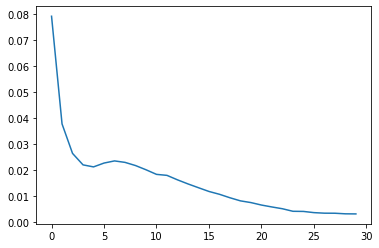

In [21]:
plt.plot(range(len(tr_losses)) , np.asarray(tr_losses).mean(1))

In [20]:
np.asarray(tr_losses).mean(1)

array([0.07925382, 0.03778575, 0.02642849, 0.02201105, 0.02123296,
       0.02270963, 0.02353474, 0.02297144, 0.02175142, 0.020127  ,
       0.01835453, 0.01796837, 0.01624757, 0.01467402, 0.01321192,
       0.01177035, 0.01068123, 0.00934028, 0.00814935, 0.00748574,
       0.00653745, 0.00579803, 0.00511126, 0.00413433, 0.00408054,
       0.00361694, 0.00340546, 0.00338286, 0.00316007, 0.00312226])

## Compute embeddings

In [7]:
model = EmbedorNN(vision_model).to(device)

In [9]:
model.load_state_dict(torch.load('data/tests_model_image/model_ep_28.pth'))

<All keys matched successfully>

In [22]:
testing_ds = TripletDS(df, small_images_dir, return_triplet = False)
testing_dl = DataLoader(testing_ds, batch_size = bs, shuffle = False, pin_memory = True)

In [23]:
embs = []
model.eval()
with torch.no_grad():
    pbar = tqdm(testing_dl)
    for image in pbar:
        x = val_transforms(image.to(device))
        y = model(x)
        embs.append(y.cpu())

In [24]:
embs = torch.cat(embs,0)

In [25]:
embs_df = pd.DataFrame(embs.numpy())
emb_cols = [f'emb_{i}' for i in embs_df.columns]
embs_df.columns = emb_cols
embs_df.to_csv('train_embs.csv')


In [26]:
embs_df.to_csv('train_embs.csv')